In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import json
import seaborn as sns
import folium
import os
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Lets have a look at the model grid data contained in the Area Peril dictionary file. Note that the dictionary is only meta-data, and not required for model execution.

In [3]:
area_peril_dictionary = pd.read_csv("./model_data/PiWind/areaperil_dict.csv")
area_peril_dictionary.head()

,areaperil_id,lon,lat,gridcell,peril
0,1,-0.914618,52.737027,1-1,windstorm
1,2,-0.908552,52.737027,2-1,windstorm
2,3,-0.902485,52.737027,3-1,windstorm
3,4,-0.896419,52.737027,4-1,windstorm
4,5,-0.890352,52.737027,5-1,windstorm


Where is the model grid? Lets plot it on a map of the UK.

In [4]:
m = folium.Map(location=[	52.737027, -0.914618], zoom_start=7, tiles='cartodbpositron')
geometry = [Polygon([
    (min(area_peril_dictionary.lon), max(area_peril_dictionary.lat)),
    (min(area_peril_dictionary.lon), min(area_peril_dictionary.lat)),
    (max(area_peril_dictionary.lon), min(area_peril_dictionary.lat)),
    (max(area_peril_dictionary.lon), max(area_peril_dictionary.lat))])]
crs = {'init': 'epsg:4326'}
d = {'Description': ['All']}
df = pd.DataFrame(data=d)
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
folium.GeoJson(gdf).add_to(m)
m.save("test_map.html")

In [5]:
%%HTML
<iframe width="100%" height=350 src="test_map.html"></iframe>

In [6]:
intensity_bin_dictionary = pd.read_csv("./model_data/PiWind/intensity_bin_dict.csv")
intensity_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,62.5,67.5,65.0,1202
1,2,67.5,72.5,70.0,1202
2,3,72.5,77.5,75.0,1202
3,4,77.5,82.5,80.0,1202
4,5,82.5,87.5,85.0,1202


In [7]:
footprints = pd.read_csv("./model_data/PiWind/footprint.csv")
footprints.head()

,event_id,area_peril_id,intensity_bin_index,prob
0,1,3,1,1
1,1,4,2,1
2,1,5,2,1
3,1,6,3,1
4,1,7,3,1


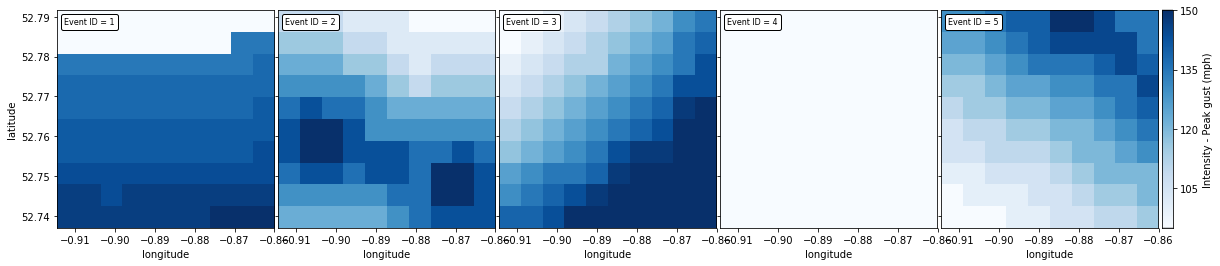

In [8]:
footprints_with_hazard = footprints.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_index', right_on='bin_index').merge(
    area_peril_dictionary, how='inner', 
    left_on='area_peril_id', right_on='areaperil_id')

fig = plt.figure(figsize=(20,10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 5),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for idx, ax in enumerate(grid):
    a = np.zeros([10, 10])
    for __, row in footprints_with_hazard[footprints_with_hazard.event_id == idx+1].iterrows():
       i, j = row.gridcell.split('-')
       a[int(i)-1, int(j)-1] = row.interpolation
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), 
                   extent=(
                       min(area_peril_dictionary.lon), max(area_peril_dictionary.lon), 
                       min(area_peril_dictionary.lat), max(area_peril_dictionary.lat)))
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    at = AnchoredText(
        "Event ID = {}".format(idx + 1),
        prop=dict(size=8),
        frameon=True,
        loc=2,
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Intensity - Peak gust (mph)")

plt.show()


In [9]:
damage_bin_dictionary = pd.read_csv("./model_data/PiWind/damage_bin_dict.csv")
damage_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.0,0.0,0.00,1203
1,2,0.0,0.1,0.05,1200
2,3,0.1,0.2,0.15,1202
3,4,0.2,0.3,0.25,1202
4,5,0.3,0.4,0.35,1202


In [10]:
vulnerabilities = pd.read_csv("./model_data/PiWind/vulnerability.csv")
vulnerabilities.head()

,vulnerability_id,intensity_bin_index,damage_bin_index,prob
0,1,1,1,0.654
1,1,1,2,0.146
2,1,1,3,0.060
3,1,1,4,0.140
4,1,2,1,0.654


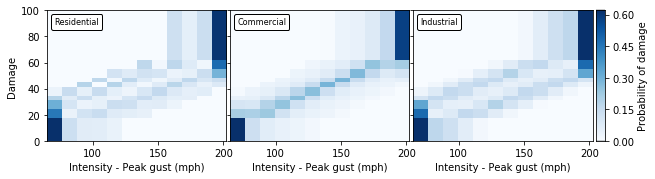

In [11]:
vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_index', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_index', right_on='bin_index')

fig = plt.figure(figsize=(10,20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.prob
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'),
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")

plt.show()




In [12]:
test_locations = pd.read_csv('tests/data/SourceLocPiWind.csv')
test_locations.head()

,ACCNTNUM,LOCNUM,POSTALCODE,STATECODE,COUNTYCODE,LATITUDE,LONGITUDE,BLDGSCHEME,BLDGCLASS,OCCSCHEME,...,WSCV5DED,WSCV6DED,WSCV7DED,WSCV8DED,WSCV9DED,WSCV10DED,WSSITELIM,WSSITEDED,WSCOMBINEDLIM,WSCOMBINEDDED
0,11111,10002082046,LE13 0HL,1,1,52.766981,-0.895470,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
1,11111,10002082047,LE13 0HL,1,1,52.766980,-0.895366,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
2,11111,10002082048,LE13 0HL,1,1,52.766978,-0.895248,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
3,11111,10002082049,LE13 0HL,1,1,52.766961,-0.895474,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
4,11111,10002082050,LE13 0HL,1,1,52.766958,-0.895353,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_accounts = pd.read_csv('tests/data/SourceAccPiWind.csv')
test_accounts.head()

,ACCNTNUM,POLICYNUM,POLICYTYPE,UNDCOVAMT,PARTOF,MINDEDAMT,MAXDEDAMT,BLANDEDAMT,BLANLIMAMT
0,11111,Layer1,2,500000,5000000,0,0,0,0.3
1,11111,Layer2,2,5500000,100000000,0,0,0,0.3


In [14]:
with open('analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "analysis_settings": {
  "gul_summaries": [
   {
    "leccalc": {
     "outputs": {
      "full_uncertainty_aep": true, 
      "full_uncertainty_oep": true
     }, 
     "return_period_file": true
    }, 
    "lec_output": true, 
    "eltcalc": true, 
    "aalcalc": true, 
    "id": 1
   }
  ], 
  "source_tag": "piwind", 
  "il_summaries": [], 
  "analysis_tag": 13, 
  "number_of_samples": 10, 
  "model_version_id": "PiWind", 
  "module_supplier_id": "OasisLMF", 
  "gul_threshold": 0, 
  "gul_output": true, 
  "exposure_location": "L:", 
  "prog_id": 12, 
  "model_settings": {
   "event_set": "P", 
   "peril_wind": true
  }
 }
}


In [ ]:
! more analysis_settings.json

{
	"analysis_settings": {
		"analysis_tag": 13,
 		"exposure_location": "L:",
 		"gul_output": true,
 		"gul_summaries": [
 			{
 				"aalcalc": true,
   				"eltcalc": true,
   				"id": 1,
   				"lec_output": true,
   				"leccalc": {
   					"outputs": {
   						"full_uncertainty_aep": true,
     					"full_uncertainty_oep": true
     				},
    			"return_period_file": true
    			}
    		}
    	],
		 "gul_threshold": 0,
		 "il_summaries": [],
		 "model_settings": {
--More--(70%)

In [ ]:
! more mdk-oasislmf-piwind.json

In [ ]:
! rm /tmp/analysis_test
! oasislmf model run -C mdk-oasislmf-piwind.json -r /tmp/analysis_test

In [ ]:
analysis_directory = "/tmp/analysis_test"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
fig, ax = plt.subplots()
eps.plot(ax=ax, kind='bar', x='return_period', y=["loss_oep", "loss_aep"])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in eps.return_period])
plt.legend(('OEP', 'AEP'))
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Loss")